ETags!
=========  ===

An unsafe "data storage" layer.

In [5]:
from typing import Any, Tuple
import json
import hashlib
from filelock import FileLock

def set_unsafe(primary_key : str, content : Any):
    serialized_content = json.dumps(content)
    with open(_get_path(primary_key), 'w') as fh:
        fh.write(serialized_content)



Why is this unsafe?
---------------------------

In [3]:
def set_unsafe(primary_key : str, content : Any):
    serialized_content = json.dumps(content)
    with open(_get_path(primary_key), 'w') as fh:
        fh.write(serialized_content)

In [9]:
# Nothing to see here... just a few utilities.

import os
storage_base = os.path.join(os.curdir, "_filestore")
os.makedirs(storage_base, exist_ok=True)

def _get_path(key : str):
    return os.path.join(storage_base, key)

def _get_etag(key : str):
    return os.path.join(storage_base, f'{key}_etag')

def _get_lock(key : str):
    return os.path.join(storage_base, f'{key}_.lock')

A Safer Alternative
--------

In [6]:
from typing import Any, Tuple
import json
import hashlib
from filelock import FileLock



def set_safe(primary_key : str, content : Any, etag : str = 'required but not set'):
    locker = FileLock(_get_lock(primary_key), timeout=1)
    with locker:
        if os.path.exists(_get_etag(primary_key)):
            stored_etag = open(_get_etag(primary_key), 'r').read()  # may throw file errors.
            if stored_etag != etag:
                msg = f"Invalid etag! Someone moved your cheese?\nOld: {stored_etag}\nNew: {etag}"
                raise ValueError(msg)
        # write etag and content
        serialized_content = json.dumps(content)
        new_etag = hashlib.md5(serialized_content.encode('ascii', 'xmlcharrefreplace'))

        with open(_get_etag(primary_key), 'w') as fh:
            fh.write(str(new_etag.hexdigest()))
        with open(_get_path(primary_key), 'w') as fh:
            fh.write(serialized_content)



In [7]:
# Here's how reading works
def get(primary_key : str) -> Tuple[Any, str]:
    try:
        with open(_get_etag(primary_key), 'r') as fh:
            etag = fh.read()
    except FileNotFoundError:
        etag = ''

    try:
        with open(_get_path(primary_key), 'r') as fh:
            content = json.loads(fh.read())
    except FileNotFoundError:
        content = {'paragraphs': {}, 'last_modified_by': 'A'}
    return content, etag

In [10]:
base_content = {
    'paragraphs': {
        0: {
            'text': "Paragraph 1",
            'author': 'A'
        }
    },
    'last_modified_by': 'A'
}
set_unsafe("blogpost", base_content)

get('blogpost')[0]

{'paragraphs': {'0': {'text': 'Paragraph 1', 'author': 'A'}},
 'last_modified_by': 'A'}

Let's break something!
-------------


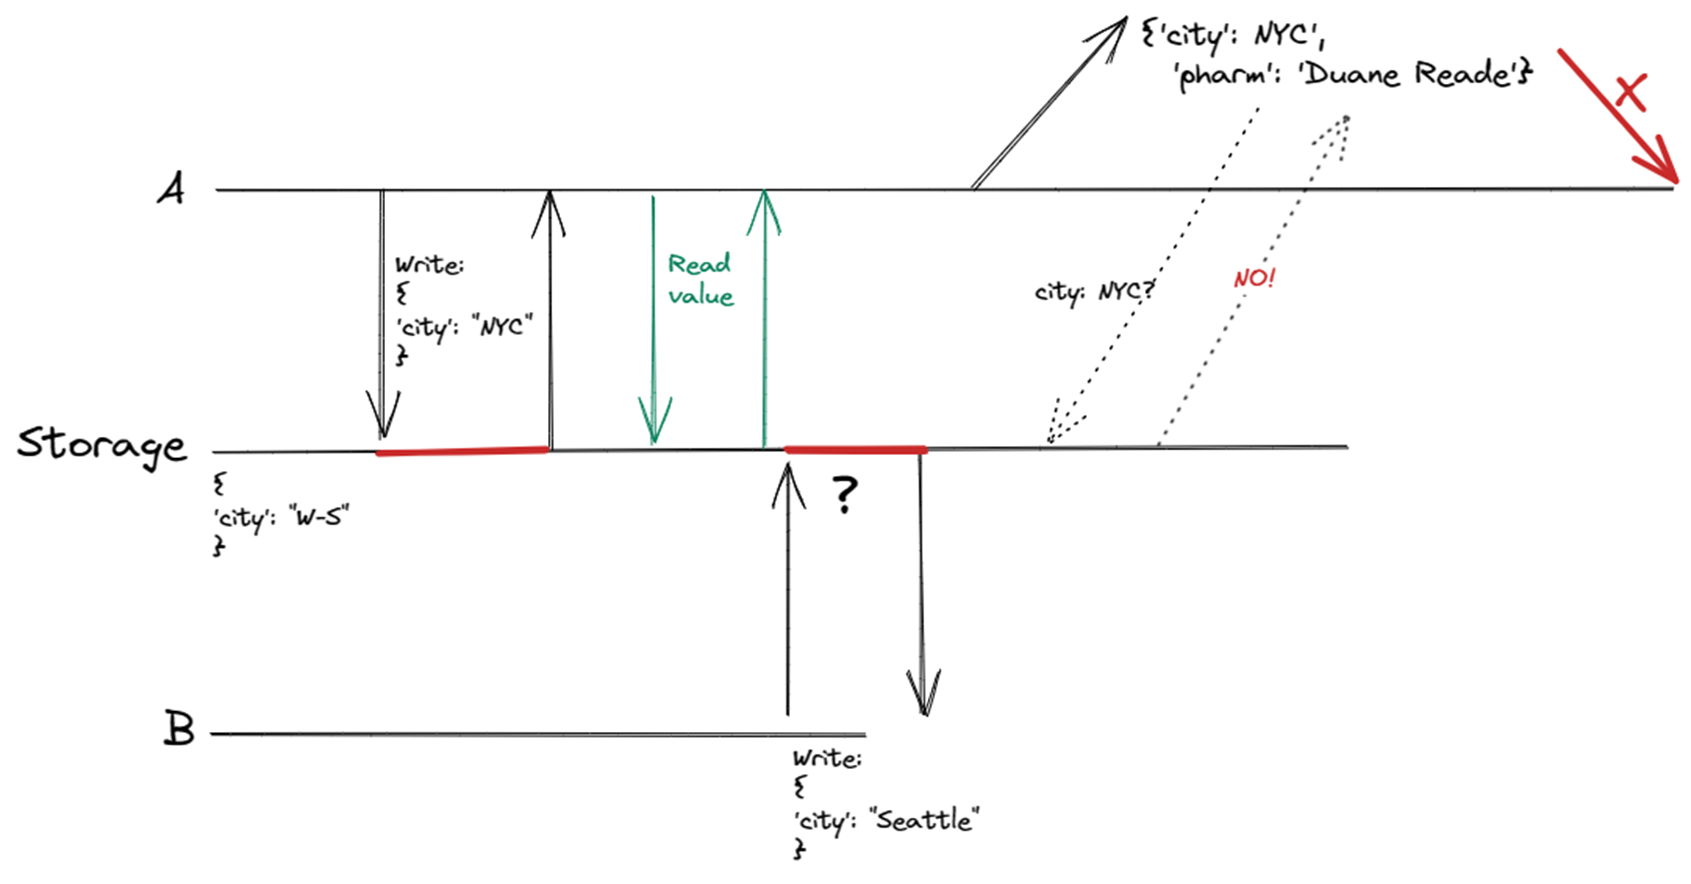

In [11]:
# Unsafe get/set

# Agent A
a_content, _ = get('blogpost')

# Agent B
b_content, _ = get('blogpost')

# Updates
a_content['last_modified_by'] = 'A'
a_content['paragraphs'][0] = {'text': 'concurrency is hard', 'author': "A"}

b_content['last_modified_by'] = 'B'
b_content['paragraphs'][1] = {'text': 'concurrency is easy!', 'author': "B"}

# Write
set_unsafe('blogpost', b_content)
get('blogpost')


({'paragraphs': {'0': {'text': 'Paragraph 1', 'author': 'A'},
   '1': {'text': 'concurrency is easy!', 'author': 'B'}},
  'last_modified_by': 'B'},
 '')

Now A will update

In [14]:
set_unsafe('blogpost', a_content)
get('blogpost')

({'paragraphs': {'0': {'text': 'concurrency is hard', 'author': 'A'}},
  'last_modified_by': 'A'},
 '')

Spot the problem?

In [9]:
set_unsafe("safeblogpost", base_content)  # for later

In [15]:
# Agent A
a_content, a_etag = get('safeblogpost')

# Agent B
b_content, b_etag = get('safeblogpost')

# Updates
a_content['last_modified_by'] = 'A'
a_content['paragraphs'][0] = {'text': 'concurrency is hard', 'author': "A"}

b_content['last_modified_by'] = 'B'
b_content['paragraphs'][1] = {'text': 'concurrency is easy!', 'author': "B"}

# Write
set_safe('safeblogpost', b_content, b_etag)

In [16]:
 set_safe('safeblogpost', a_content, a_etag)

ValueError: Invalid etag! Someone moved your cheese?
Old: 29227b18b915da397d94aecbc56f82c9
New: 9cb2de02c820676a61a22e5a9a18ee82

Now for a real example using Azure Blobs
-----------------------------

In [ ]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient

# Create a BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient.from_connection_string("<connection_string>")

# Create a new container
container_client = blob_service_client.create_container("<container_name>")

# Create a new blob
blob_client = container_client.get_blob_client("<blob_name>")

# Upload content to the blob
data = b"Hello, World!"
blob_client.upload_blob(data, overwrite=True)

# Attempt to write to the blob again with a bad etag
data = b"Hello, World Again!"
try:
    blob_client.upload_blob(data, overwrite=True, etag="<bad_etag>")
except Exception as e:
    print(e)

Locker
======

(Hope we have time!) 


In [8]:
import time
def set_safe(primary_key : str, content : Any, etag : str = 'required but not set', owner='', sleep=0):
    if owner:
        print(f"{owner} getting a lock")
    locker = FileLock(_get_lock(primary_key), timeout=1)
    with locker:
        if owner:
            print(f"{owner} has a lock")

        time.sleep(sleep)

        if os.path.exists(_get_etag(primary_key)):
            stored_etag = open(_get_etag(primary_key), 'r').read()  # may throw file errors.
            if stored_etag != etag:
                msg = f"Invalid etag! Someone moved your cheese?\nOld: {stored_etag}\nNew: {etag}"
                raise ValueError(msg)
        # write etag and content
        serialized_content = json.dumps(content)
        new_etag = hashlib.md5(serialized_content.encode('ascii', 'xmlcharrefreplace'))

        with open(_get_etag(primary_key), 'w') as fh:
            fh.write(str(new_etag.hexdigest()))
        with open(_get_path(primary_key), 'w') as fh:
            fh.write(serialized_content)
    if owner:
        print(f"{owner} releasing the lock")

In [3]:
def run_A():
    while True:
        content, tag = get('lockerblob')
        content['paragraphs'][100] = {
                    'text': "Paragaph 1",
                    'author': 'A'
                }
        content['last_modified_by'] = 'A'
        try:
            set_safe('lockerblob', content, tag, owner='A', sleep=1)
        except ValueError:
            print("A Failed! Retry")
        else:
            break
    
    
def run_B():
    while True:
        content, tag = get('lockerblob')
        content['paragraphs'][200] = {
                    'text': "Paragaph 1",
                    'author': 'B'
                }
        content['last_modified_by'] = 'B'
        try:
            set_safe('lockerblob', content, tag, owner='B', sleep=2)
        except ValueError:
            print("B Failed! Retry")
        else:
            break

In [4]:
from threading import Thread

workers = [Thread(target=run_A), Thread(target=run_B)]
[w.start() for w in workers]
[w.join() for w in workers]


A getting a lock
A has a lock
B getting a lock
A releasing the lock
B has a lock
B releasing the lock


[None, None]

Show a sample that fails!

In [11]:
def run_A():
    while True:
        content, tag = get('lockerblob')
        time.sleep(1)
        content['paragraphs'][100] = {
                    'text': "Paragaph 1",
                    'author': 'A'
                }
        content['last_modified_by'] = 'A'
        try:
            set_safe('lockerblob', content, tag, owner='A', sleep=0)
        except ValueError:
            print("A Failed! Retry")
        else:
            break
    
    
def run_B():
    while True:
        content, tag = get('lockerblob')
        time.sleep(2)
        content['paragraphs'][200] = {
                    'text': "Paragaph 1",
                    'author': 'B'
                }
        content['last_modified_by'] = 'B'
        try:
            set_safe('lockerblob', content, tag, owner='B', sleep=0)
        except ValueError:
            print("B Failed! Retry")
        else:
            break

In [13]:
from threading import Thread

workers = [Thread(target=run_A), Thread(target=run_B)]
[w.start() for w in workers]
[w.join() for w in workers]

get('lockerblob')

A getting a lock
A has a lock
A releasing the lock
B getting a lock
B has a lock
B Failed! Retry
B getting a lock
B has a lock
B releasing the lock


({'paragraphs': {'100': {'text': 'Paragaph 1', 'author': 'A'},
   '200': {'text': 'Paragaph 1', 'author': 'B'}},
  'last_modified_by': 'B'},
 'f4250679d8c65859f0e8a440ec2906d5')